<a href="https://colab.research.google.com/github/poojamahajan0712/Assign10_EVA/blob/master/S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

S10 - Assignment 

Assignment: 

1.Pick your last code<br>
2.Make sure  to Add CutOut to your code. It should come from your transformations (albumentations)<br>
3.Use this repo: https://github.com/davidtvs/pytorch-lr-finder (Links to an external site.) 
    Move LR Finder code to your modules<br>
    Implement LR Finder (for SGD, not for ADAM)<br>
    Implement ReduceLROnPlatea: https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau (Links to an external site.)<br>
4.Find best LR to train your model <br>
5.Use SDG with Momentum<br>
6.Train for 50 Epochs.<br>
7.Show Training and Test Accuracy curves<br>
8.Target 88% Accuracy.<br>
9.Run GradCAM on the any 25 misclassified images. Make sure you mention what is the prediction and what was the ground truth label.<br>
10.Submit


In [0]:
%matplotlib inline
!pip install albumentations==0.4.5
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from PIL import Image

from data_load_cifar10 import dataload
from util1 import *
import resnet
import gradcam
from train_v1 import train
from new_test1 import test
from album import album_train,album_test
from visualize_v1 import VisualizeCam




In [0]:

    
trainloader,testloader,classes =dataload(train_transform=album_train(),test_transorm=album_test())


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   dog plane   cat


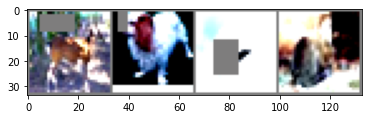

In [0]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:

device = which_device()
net = resnet.ResNet18().to(device)
show_model_summary(net, device, (3,32,32))




----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

 **Define a Loss function and optimizer** 


**Training and Testing**





In [0]:
import torch.nn as nn
from torch.optim import SGD,Adam
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer=SGD(net.parameters(), lr=0.00001)
lr_finder=LRFinder(net,optimizer,criterion,device="cuda")
lr_finder.range_test(trainloader,end_lr=1,num_iter=500,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


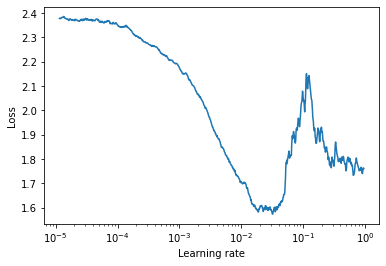

In [0]:
lr_finder.plot()

In [0]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)
def run():
  train_accs,test_losses,test_accs,pred_wrong_t,true_wrong_t,image_t=([] for i in range(6))
  n=50
  for epoch in range(n):
      print("EPOCH:", epoch+1)
      
      train(net, device, trainloader, criterion, optimizer, epoch,train_accs)
      test((epoch==(n-1)),net, device, testloader, criterion, classes, test_losses, test_accs,pred_wrong_t,true_wrong_t,image_t)
      scheduler.step(epoch)
  return(train_accs,test_accs,pred_wrong_t,true_wrong_t,image_t)
 

train_accs,test_accs,pred_wrong_t,true_wrong_t,image_t=run()

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.614898443222046 Batch_id=390 Accuracy=37.78: 100%|██████████| 391/391 [00:53<00:00,  7.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0100, Accuracy: 5304/10000 (53.04%)

EPOCH: 2


Loss=1.1526892185211182 Batch_id=390 Accuracy=56.92: 100%|██████████| 391/391 [00:54<00:00,  7.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0087, Accuracy: 6081/10000 (60.81%)

EPOCH: 3


Loss=1.0374490022659302 Batch_id=390 Accuracy=65.41: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0072, Accuracy: 6755/10000 (67.55%)

EPOCH: 4


Loss=0.6315101981163025 Batch_id=390 Accuracy=70.86: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7585/10000 (75.85%)

EPOCH: 5


Loss=0.5323065519332886 Batch_id=390 Accuracy=75.35: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0055, Accuracy: 7522/10000 (75.22%)

EPOCH: 6


Loss=0.44599056243896484 Batch_id=390 Accuracy=78.79: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0048, Accuracy: 7891/10000 (78.91%)

EPOCH: 7


Loss=0.6381877660751343 Batch_id=390 Accuracy=81.30: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0054, Accuracy: 7791/10000 (77.91%)

EPOCH: 8


Loss=0.35089871287345886 Batch_id=390 Accuracy=83.37: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0046, Accuracy: 8074/10000 (80.74%)

EPOCH: 9


Loss=0.5074008703231812 Batch_id=390 Accuracy=85.10: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0043, Accuracy: 8233/10000 (82.33%)

EPOCH: 10


Loss=0.35273170471191406 Batch_id=390 Accuracy=86.53: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0039, Accuracy: 8337/10000 (83.37%)

EPOCH: 11


Loss=0.47792404890060425 Batch_id=390 Accuracy=87.68: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0041, Accuracy: 8345/10000 (83.45%)

EPOCH: 12


Loss=0.1943158209323883 Batch_id=390 Accuracy=88.80: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Test set: Average loss: 0.0042, Accuracy: 8305/10000 (83.05%)

Epoch    12: reducing learning rate of group 0 to 3.0000e-03.
EPOCH: 13


Loss=0.1940644532442093 Batch_id=390 Accuracy=93.19: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 77 %
Accuracy of   cat : 60 %
Accuracy of  deer : 89 %
Accuracy of   dog : 78 %
Accuracy of  frog : 88 %
Accuracy of horse : 96 %
Accuracy of  ship : 94 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0031, Accuracy: 8742/10000 (87.42%)

EPOCH: 14


Loss=0.1359783113002777 Batch_id=390 Accuracy=94.34: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 100 %
Accuracy of  bird : 76 %
Accuracy of   cat : 74 %
Accuracy of  deer : 85 %
Accuracy of   dog : 84 %
Accuracy of  frog : 91 %
Accuracy of horse : 93 %
Accuracy of  ship : 89 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0031, Accuracy: 8783/10000 (87.83%)

EPOCH: 15


Loss=0.11690058559179306 Batch_id=390 Accuracy=94.99: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 93 %
Accuracy of  bird : 85 %
Accuracy of   cat : 70 %
Accuracy of  deer : 90 %
Accuracy of   dog : 89 %
Accuracy of  frog : 100 %
Accuracy of horse : 88 %
Accuracy of  ship : 91 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0032, Accuracy: 8772/10000 (87.72%)

EPOCH: 16


Loss=0.10261712223291397 Batch_id=390 Accuracy=95.45: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 80 %
Accuracy of   car : 96 %
Accuracy of  bird : 90 %
Accuracy of   cat : 80 %
Accuracy of  deer : 74 %
Accuracy of   dog : 77 %
Accuracy of  frog : 85 %
Accuracy of horse : 90 %
Accuracy of  ship : 96 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0033, Accuracy: 8779/10000 (87.79%)

EPOCH: 17


Loss=0.13946913182735443 Batch_id=390 Accuracy=95.73: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 96 %
Accuracy of  bird : 96 %
Accuracy of   cat : 73 %
Accuracy of  deer : 91 %
Accuracy of   dog : 73 %
Accuracy of  frog : 75 %
Accuracy of horse : 92 %
Accuracy of  ship : 88 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0033, Accuracy: 8818/10000 (88.18%)

EPOCH: 18


Loss=0.2055720090866089 Batch_id=390 Accuracy=96.10: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 75 %
Accuracy of   cat : 73 %
Accuracy of  deer : 85 %
Accuracy of   dog : 88 %
Accuracy of  frog : 90 %
Accuracy of horse : 91 %
Accuracy of  ship : 90 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0035, Accuracy: 8777/10000 (87.77%)

EPOCH: 19


Loss=0.13125211000442505 Batch_id=390 Accuracy=96.38: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 93 %
Accuracy of  bird : 75 %
Accuracy of   cat : 78 %
Accuracy of  deer : 82 %
Accuracy of   dog : 72 %
Accuracy of  frog : 100 %
Accuracy of horse : 83 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0034, Accuracy: 8796/10000 (87.96%)

EPOCH: 20


Loss=0.12979908287525177 Batch_id=390 Accuracy=96.71: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 92 %
Accuracy of  bird : 82 %
Accuracy of   cat : 89 %
Accuracy of  deer : 87 %
Accuracy of   dog : 89 %
Accuracy of  frog : 97 %
Accuracy of horse : 91 %
Accuracy of  ship : 96 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0034, Accuracy: 8805/10000 (88.05%)

EPOCH: 21


Loss=0.16986918449401855 Batch_id=390 Accuracy=96.80: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 91 %
Accuracy of  bird : 83 %
Accuracy of   cat : 72 %
Accuracy of  deer : 100 %
Accuracy of   dog : 81 %
Accuracy of  frog : 91 %
Accuracy of horse : 85 %
Accuracy of  ship : 90 %
Accuracy of truck : 87 %

Test set: Average loss: 0.0035, Accuracy: 8800/10000 (88.00%)

EPOCH: 22


Loss=0.048717908561229706 Batch_id=390 Accuracy=97.10: 100%|██████████| 391/391 [00:54<00:00,  7.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 80 %
Accuracy of   car : 92 %
Accuracy of  bird : 84 %
Accuracy of   cat : 77 %
Accuracy of  deer : 88 %
Accuracy of   dog : 81 %
Accuracy of  frog : 90 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0035, Accuracy: 8799/10000 (87.99%)

EPOCH: 23


Loss=0.0996563732624054 Batch_id=390 Accuracy=97.35: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 84 %
Accuracy of   car : 92 %
Accuracy of  bird : 90 %
Accuracy of   cat : 66 %
Accuracy of  deer : 87 %
Accuracy of   dog : 75 %
Accuracy of  frog : 83 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0036, Accuracy: 8796/10000 (87.96%)

Epoch    23: reducing learning rate of group 0 to 3.0000e-04.
EPOCH: 24


Loss=0.06421731412410736 Batch_id=390 Accuracy=97.73: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 90 %
Accuracy of  bird : 76 %
Accuracy of   cat : 61 %
Accuracy of  deer : 75 %
Accuracy of   dog : 78 %
Accuracy of  frog : 97 %
Accuracy of horse : 87 %
Accuracy of  ship : 92 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0036, Accuracy: 8819/10000 (88.19%)

EPOCH: 25


Loss=0.038125403225421906 Batch_id=390 Accuracy=97.79: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 86 %
Accuracy of   car : 96 %
Accuracy of  bird : 82 %
Accuracy of   cat : 68 %
Accuracy of  deer : 85 %
Accuracy of   dog : 74 %
Accuracy of  frog : 84 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0035, Accuracy: 8816/10000 (88.16%)

EPOCH: 26


Loss=0.03287797048687935 Batch_id=390 Accuracy=97.82: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 97 %
Accuracy of  bird : 86 %
Accuracy of   cat : 79 %
Accuracy of  deer : 84 %
Accuracy of   dog : 70 %
Accuracy of  frog : 91 %
Accuracy of horse : 87 %
Accuracy of  ship : 91 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0035, Accuracy: 8825/10000 (88.25%)

EPOCH: 27


Loss=0.06331957131624222 Batch_id=390 Accuracy=97.81: 100%|██████████| 391/391 [00:54<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 82 %
Accuracy of  bird : 76 %
Accuracy of   cat : 71 %
Accuracy of  deer : 80 %
Accuracy of   dog : 85 %
Accuracy of  frog : 82 %
Accuracy of horse : 100 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0035, Accuracy: 8821/10000 (88.21%)

EPOCH: 28


Loss=0.029761213809251785 Batch_id=390 Accuracy=97.99: 100%|██████████| 391/391 [00:54<00:00,  7.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 85 %
Accuracy of   car : 90 %
Accuracy of  bird : 89 %
Accuracy of   cat : 72 %
Accuracy of  deer : 92 %
Accuracy of   dog : 85 %
Accuracy of  frog : 93 %
Accuracy of horse : 95 %
Accuracy of  ship : 100 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0035, Accuracy: 8818/10000 (88.18%)

EPOCH: 29


Loss=0.03331546112895012 Batch_id=390 Accuracy=97.84: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 97 %
Accuracy of  bird : 85 %
Accuracy of   cat : 66 %
Accuracy of  deer : 85 %
Accuracy of   dog : 82 %
Accuracy of  frog : 92 %
Accuracy of horse : 93 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0036, Accuracy: 8828/10000 (88.28%)

EPOCH: 30


Loss=0.023824775591492653 Batch_id=390 Accuracy=97.97: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 80 %
Accuracy of   cat : 63 %
Accuracy of  deer : 77 %
Accuracy of   dog : 84 %
Accuracy of  frog : 83 %
Accuracy of horse : 83 %
Accuracy of  ship : 97 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0035, Accuracy: 8833/10000 (88.33%)

EPOCH: 31


Loss=0.06794016063213348 Batch_id=390 Accuracy=98.03: 100%|██████████| 391/391 [00:54<00:00,  7.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 90 %
Accuracy of   car : 100 %
Accuracy of  bird : 91 %
Accuracy of   cat : 82 %
Accuracy of  deer : 92 %
Accuracy of   dog : 90 %
Accuracy of  frog : 90 %
Accuracy of horse : 100 %
Accuracy of  ship : 93 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0035, Accuracy: 8846/10000 (88.46%)

EPOCH: 32


Loss=0.06997712701559067 Batch_id=390 Accuracy=97.95: 100%|██████████| 391/391 [00:55<00:00,  7.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 97 %
Accuracy of  bird : 72 %
Accuracy of   cat : 74 %
Accuracy of  deer : 84 %
Accuracy of   dog : 86 %
Accuracy of  frog : 90 %
Accuracy of horse : 100 %
Accuracy of  ship : 91 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0035, Accuracy: 8834/10000 (88.34%)

EPOCH: 33


Loss=0.1017017737030983 Batch_id=390 Accuracy=98.00: 100%|██████████| 391/391 [00:55<00:00,  7.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 80 %
Accuracy of   car : 92 %
Accuracy of  bird : 82 %
Accuracy of   cat : 82 %
Accuracy of  deer : 94 %
Accuracy of   dog : 79 %
Accuracy of  frog : 92 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0035, Accuracy: 8833/10000 (88.33%)

EPOCH: 34


Loss=0.11555067449808121 Batch_id=390 Accuracy=97.92: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 96 %
Accuracy of   car : 96 %
Accuracy of  bird : 86 %
Accuracy of   cat : 74 %
Accuracy of  deer : 85 %
Accuracy of   dog : 90 %
Accuracy of  frog : 85 %
Accuracy of horse : 95 %
Accuracy of  ship : 90 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0035, Accuracy: 8824/10000 (88.24%)

Epoch    34: reducing learning rate of group 0 to 3.0000e-05.
EPOCH: 35


Loss=0.06355157494544983 Batch_id=390 Accuracy=98.04: 100%|██████████| 391/391 [00:54<00:00,  7.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 89 %
Accuracy of   car : 89 %
Accuracy of  bird : 77 %
Accuracy of   cat : 88 %
Accuracy of  deer : 80 %
Accuracy of   dog : 86 %
Accuracy of  frog : 95 %
Accuracy of horse : 92 %
Accuracy of  ship : 88 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0035, Accuracy: 8838/10000 (88.38%)

EPOCH: 36


Loss=0.014465129002928734 Batch_id=390 Accuracy=98.22: 100%|██████████| 391/391 [00:55<00:00,  7.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 88 %
Accuracy of   car : 95 %
Accuracy of  bird : 85 %
Accuracy of   cat : 62 %
Accuracy of  deer : 92 %
Accuracy of   dog : 76 %
Accuracy of  frog : 89 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0035, Accuracy: 8832/10000 (88.32%)

EPOCH: 37


Loss=0.060312945395708084 Batch_id=390 Accuracy=98.02: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 88 %
Accuracy of   cat : 90 %
Accuracy of  deer : 86 %
Accuracy of   dog : 86 %
Accuracy of  frog : 85 %
Accuracy of horse : 97 %
Accuracy of  ship : 90 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0035, Accuracy: 8828/10000 (88.28%)

EPOCH: 38


Loss=0.06257744133472443 Batch_id=390 Accuracy=98.12: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 93 %
Accuracy of  bird : 88 %
Accuracy of   cat : 69 %
Accuracy of  deer : 94 %
Accuracy of   dog : 75 %
Accuracy of  frog : 100 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 87 %

Test set: Average loss: 0.0035, Accuracy: 8837/10000 (88.37%)

EPOCH: 39


Loss=0.029447834938764572 Batch_id=390 Accuracy=98.02: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 93 %
Accuracy of   car : 90 %
Accuracy of  bird : 90 %
Accuracy of   cat : 80 %
Accuracy of  deer : 90 %
Accuracy of   dog : 82 %
Accuracy of  frog : 83 %
Accuracy of horse : 87 %
Accuracy of  ship : 94 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0035, Accuracy: 8835/10000 (88.35%)

EPOCH: 40


Loss=0.020150303840637207 Batch_id=390 Accuracy=98.08: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 82 %
Accuracy of   car : 89 %
Accuracy of  bird : 78 %
Accuracy of   cat : 58 %
Accuracy of  deer : 93 %
Accuracy of   dog : 73 %
Accuracy of  frog : 93 %
Accuracy of horse : 96 %
Accuracy of  ship : 95 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0035, Accuracy: 8832/10000 (88.32%)

EPOCH: 41


Loss=0.06724394857883453 Batch_id=390 Accuracy=98.06: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 93 %
Accuracy of  bird : 83 %
Accuracy of   cat : 80 %
Accuracy of  deer : 80 %
Accuracy of   dog : 84 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0035, Accuracy: 8828/10000 (88.28%)

EPOCH: 42


Loss=0.05969129130244255 Batch_id=390 Accuracy=98.18: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 96 %
Accuracy of  bird : 83 %
Accuracy of   cat : 77 %
Accuracy of  deer : 93 %
Accuracy of   dog : 72 %
Accuracy of  frog : 97 %
Accuracy of horse : 90 %
Accuracy of  ship : 95 %
Accuracy of truck : 93 %

Test set: Average loss: 0.0035, Accuracy: 8832/10000 (88.32%)

EPOCH: 43


Loss=0.10948560386896133 Batch_id=390 Accuracy=98.00: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 97 %
Accuracy of  bird : 88 %
Accuracy of   cat : 85 %
Accuracy of  deer : 90 %
Accuracy of   dog : 73 %
Accuracy of  frog : 93 %
Accuracy of horse : 93 %
Accuracy of  ship : 85 %
Accuracy of truck : 88 %

Test set: Average loss: 0.0037, Accuracy: 8835/10000 (88.35%)

EPOCH: 44


Loss=0.06367960572242737 Batch_id=390 Accuracy=98.07: 100%|██████████| 391/391 [00:55<00:00,  7.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 100 %
Accuracy of  bird : 87 %
Accuracy of   cat : 70 %
Accuracy of  deer : 93 %
Accuracy of   dog : 76 %
Accuracy of  frog : 85 %
Accuracy of horse : 96 %
Accuracy of  ship : 92 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0035, Accuracy: 8831/10000 (88.31%)

EPOCH: 45


Loss=0.07176528871059418 Batch_id=390 Accuracy=98.06: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 83 %
Accuracy of   cat : 77 %
Accuracy of  deer : 93 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 93 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0035, Accuracy: 8821/10000 (88.21%)

Epoch    45: reducing learning rate of group 0 to 3.0000e-06.
EPOCH: 46


Loss=0.06054260581731796 Batch_id=390 Accuracy=98.15: 100%|██████████| 391/391 [00:55<00:00,  7.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 82 %
Accuracy of  bird : 86 %
Accuracy of   cat : 86 %
Accuracy of  deer : 87 %
Accuracy of   dog : 87 %
Accuracy of  frog : 89 %
Accuracy of horse : 88 %
Accuracy of  ship : 92 %
Accuracy of truck : 100 %

Test set: Average loss: 0.0036, Accuracy: 8830/10000 (88.30%)

EPOCH: 47


Loss=0.0328463539481163 Batch_id=390 Accuracy=98.15: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 87 %
Accuracy of   car : 97 %
Accuracy of  bird : 88 %
Accuracy of   cat : 76 %
Accuracy of  deer : 96 %
Accuracy of   dog : 81 %
Accuracy of  frog : 90 %
Accuracy of horse : 92 %
Accuracy of  ship : 94 %
Accuracy of truck : 96 %

Test set: Average loss: 0.0035, Accuracy: 8831/10000 (88.31%)

EPOCH: 48


Loss=0.07030738890171051 Batch_id=390 Accuracy=98.09: 100%|██████████| 391/391 [00:55<00:00,  7.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 97 %
Accuracy of   car : 94 %
Accuracy of  bird : 97 %
Accuracy of   cat : 77 %
Accuracy of  deer : 93 %
Accuracy of   dog : 92 %
Accuracy of  frog : 92 %
Accuracy of horse : 86 %
Accuracy of  ship : 100 %
Accuracy of truck : 97 %

Test set: Average loss: 0.0036, Accuracy: 8835/10000 (88.35%)

EPOCH: 49


Loss=0.07645706087350845 Batch_id=390 Accuracy=98.14: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Accuracy of plane : 100 %
Accuracy of   car : 96 %
Accuracy of  bird : 93 %
Accuracy of   cat : 75 %
Accuracy of  deer : 80 %
Accuracy of   dog : 85 %
Accuracy of  frog : 91 %
Accuracy of horse : 88 %
Accuracy of  ship : 96 %
Accuracy of truck : 90 %

Test set: Average loss: 0.0036, Accuracy: 8825/10000 (88.25%)

EPOCH: 50


Loss=0.06372511386871338 Batch_id=390 Accuracy=98.18: 100%|██████████| 391/391 [00:54<00:00,  7.12it/s]



Accuracy of plane : 92 %
Accuracy of   car : 91 %
Accuracy of  bird : 86 %
Accuracy of   cat : 65 %
Accuracy of  deer : 90 %
Accuracy of   dog : 77 %
Accuracy of  frog : 92 %
Accuracy of horse : 96 %
Accuracy of  ship : 91 %
Accuracy of truck : 86 %

Test set: Average loss: 0.0035, Accuracy: 8833/10000 (88.33%)



In [0]:
'''
from google.colab import files
figure = plt.figure(figsize=(10, 10))
num_of_images = 25
for index in range(1, num_of_images+1):
    plt.subplot(5,5, index)
    plt.axis('off')
    plt.imshow(np.transpose(images[index], (1, 2, 0)))
    a='P-'+str(classes[pred_wrong_t[index]])+"  A-"+str(classes[true_wrong_t[index]])
    plt.title(a)'''

'\nfrom google.colab import files\nfigure = plt.figure(figsize=(10, 10))\nnum_of_images = 25\nfor index in range(1, num_of_images+1):\n    plt.subplot(5,5, index)\n    plt.axis(\'off\')\n    plt.imshow(np.transpose(images[index], (1, 2, 0)))\n    a=\'P-\'+str(classes[pred_wrong_t[index]])+"  A-"+str(classes[true_wrong_t[index]])\n    plt.title(a)'

In [0]:
print(int(pred_wrong_t[0]))

8


'extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())\nfig.savefig(\'Accuracy_S6.png\', bbox_inches=extent.expanded(1.1, 1.2))\nfiles.download("Accuracy_S6.png") '

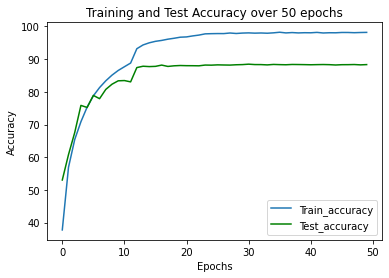

In [0]:
from google.colab import files
plt.plot(train_accs[:], label="Train_accuracy")
plt.plot(test_accs[:], color="green", label="Test_accuracy")
plt.title("Training and Test Accuracy over 50 epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

'''extent = ax1.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('Accuracy_S6.png', bbox_inches=extent.expanded(1.1, 1.2))
files.download("Accuracy_S6.png") '''


GroundTruth:   frog truck  frog  deer


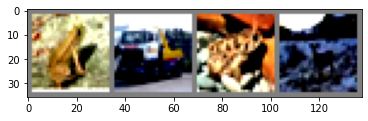

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = VisualizeCam(net,classes, target_layers)

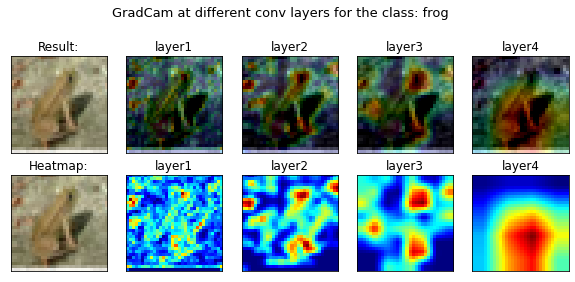

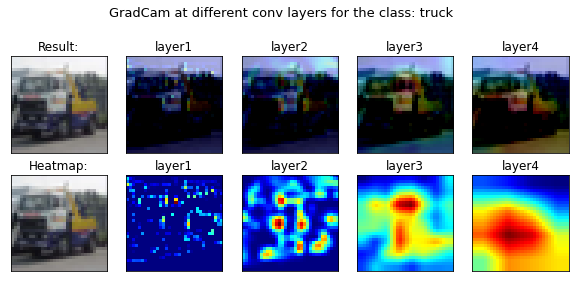

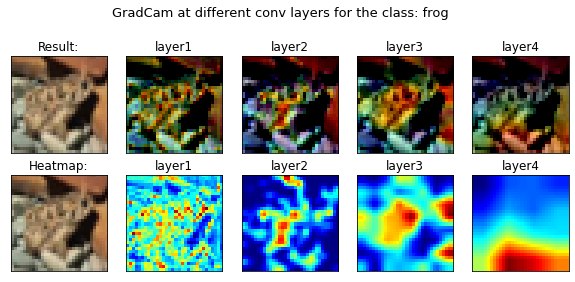

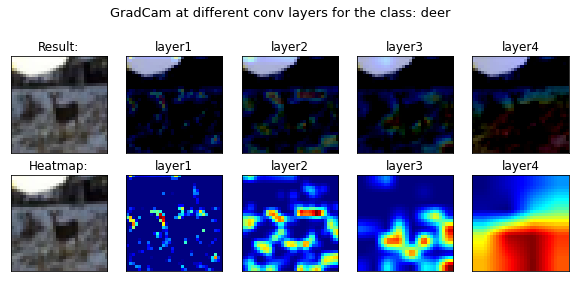

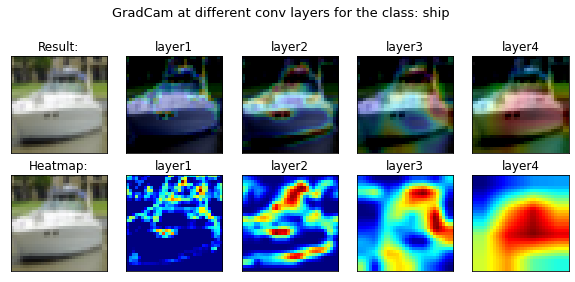

In [0]:
incorrect_pred_imgs = []
for i in range(25):
  incorrect_pred_imgs.append(torch.as_tensor(images[i]))
viz_cam(torch.stack(incorrect_pred_imgs), target_layers, metric="incorrect")

Okay, now let us see what the neural network thinks these examples above are:
The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:


In [0]:
images=images.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog truck  frog  deer


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

